# NEMO Example 

For this example, the NEMO output files have already been saved as netCDF with the right coordinate names. The [xorca](https://github.com/willirath/xorca) package is designed to open NEMO datasets so they are understandable by xgcm. The [xnemogcm](https://github.com/rcaneill/xnemogcm) does a similar work on idealized configurations.

Below are some example of how to make calculations using xgcm.

First we import xarray and xgcm:

In [17]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,10)

Now we open the NEMO example dataset, from the BASIN configuration. The *ds* dataset contains the variables data (e.g. temperature, velocities) while the *domcfg* dataset contains the grid data (position, scale factor, etc).

We get a dataset produced for the purpose of this documentation 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3736803.svg)](https://doi.org/10.5281/zenodo.3736803).
In this dataset, we have not outputed the vertical scale factors in the *file_def_nemo-oce.xml* to save space. In a real case, the scale factors need to be saved to use properly the "thickness weighted" variables. The *domcfg* dataset has also been filtered to remove many unused variables in this notebook (e.g. *umask*).

In [18]:
# download the data
import urllib.request
import shutil

url = 'https://zenodo.org/record/3736803/files/'
file_name_domcfg = 'xnemogcm.domcfg.nc'
with urllib.request.urlopen(url + file_name_domcfg) as response, open(file_name_domcfg, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
file_name_basin = 'xnemogcm.nemo.nc'
with urllib.request.urlopen(url + file_name_basin) as response, open(file_name_basin, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    
# open the data
domcfg = xr.open_dataset(file_name_domcfg)
ds = xr.open_dataset(file_name_basin)

Add the vertical scale factors to *ds* (output of the model in real cases):

In [19]:
points = ['t', 'u', 'v', 'f', 'w']
for point in points:
    ds[f"e3{point}"] = domcfg[f"e3{point}_0"]

In [20]:
print('\n domcfg \n', domcfg)
print('\n ds \n', ds)


 domcfg 
 <xarray.Dataset>
Dimensions:    (x_c: 20, x_f: 20, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * x_c        (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y_c        (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * x_f        (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 15.5 16.5 17.5 18.5 19.5
  * y_f        (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 35.5 36.5 37.5 38.5 39.5
  * z_c        (z_c) float32 5.0 15.0 25.0 35.0 ... 3379.915 3786.7092 4219.6006
  * z_f        (z_f) float32 4.5 14.5 24.5 34.5 ... 3379.415 3786.2092 4219.1006
Data variables:
    glamt      (y_c, x_c) float64 ...
    glamf      (y_f, x_f) float64 ...
    gphit      (y_c, x_c) float64 ...
    gphif      (y_f, x_f) float64 ...
    e1t        (y_c, x_c) float64 ...
    e1u        (y_c, x_f) float64 ...
    e1v        (y_f, x_c) float64 ...
    e1f        (y_f, x_f) float64 ...
    e2t        (y_c, x_c) float64 ...
    e2u        (y_c, x_f) float64 ...
    e2v        (y

In the coordinates, the *_c* suffix means *center* while the *_f* suffix means *face*. Thus the (x_c, y_c, z_c) point is the T point, the (x_c, y_f, z_c) is the V point, etc.

## Geometry of the basin
The geometry of the simulation is a closed basin, with a bottom bathymetry, going from 2000 m at the coasts, to 4000 m in the interior of the basin. Terrain following coordinates are used and the free surface is linear (fixed vertical levels).
A 2 degrees Mercator grid is used.

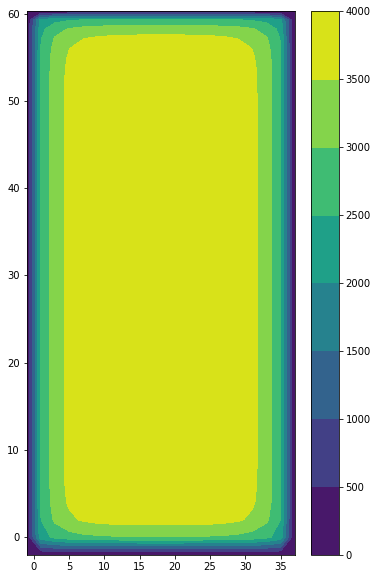

In [5]:
plt.contourf(domcfg.glamt, domcfg.gphit, domcfg.ht_0)
plt.colorbar()

## Creating the grid object

Next we create a `Grid` object from the dataset.
All the axes are here non-periodic.
The `metrics` dict contains the scale factors.

In [6]:

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
grid = xgcm.Grid(domcfg, metrics=metrics, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic):
  * center   y_c --> right
  * right    y_f --> center
X Axis (not periodic):
  * center   x_c --> right
  * right    x_f --> center
Z Axis (not periodic):
  * center   z_c --> left
  * left     z_f --> center


We see that xgcm identified three different axes: X (longitude), Y (latitude), Z (depth).

## Computation examples
### Horizontal gradient of SST

We will compute the horizontal component of the gradient of SST in the longitude
direction as a first example to understand the logic behind the
xgcm grids.

We want to compute
$\frac{\partial SST}{\partial x}$.
The SST is the variable `tos` (Temperature Ocean Surface) in our dataset.

In discrete form, using the NEMO notation, the derivative becomes [1]

$$\frac{\partial SST}{\partial x} = \frac{1}{e_{1u}} \delta_{i+1/2} SST
= \frac{1}{e_{1u}} (SST_{i+1} - SST_i) \ .$$

The last T point is an earth point here, such as the 2 last U points: we set up the
`boundary` argument to 'fill' and the fill value to zero (this value does not play an important role here, as we fill earth points).

The gradient is first computed with the `diff` function and
then with the `derivative` function, the result is the same as the `derivative`
function is aware of which scale factor to use.

<hr>
[1] NEMO book v4.0.1, pp 22

In [7]:
grad_T_lon0 = grid.diff(ds.tos, axis='X', boundary='fill', fill_value=0) / domcfg.e1u
grad_T_lon1 = grid.derivative(ds.tos, axis='X', boundary='fill', fill_value=0)
print(grad_T_lon1.coords)
(grad_T_lon0 == grad_T_lon1).all()

Coordinates:
  * t        (t) object 1050-07-01 00:00:00
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 15.5 16.5 17.5 18.5 19.5


<xarray.DataArray ()>
array(True)

As expected the result of the 2 operations is the same.
The position of the derivative is now on the U point.

### Divergence Calculation

Here we show how to calculate the divergence of the flow.
The precise details of how to do this calculation are highly model- and configuration-dependent (e.g. free-surface vs. rigid lid, etc.)
In this example, the flow is incompressible, without precipitations
or evaporation, with a linear free surface, satisfying the continuity equation

$$ \vec{\nabla} \cdot \vec{u} = 
  \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
  + \frac{\partial w}{\partial z} = 0 \ .$$
  
In non-linear free surface, the divergence of $\vec{u}$ is not 0 anymore, it is linked to
the time variation of the $e_{3}$ scale factors.

In discrete form, using NEMO notation, the equation becomes [1]

$$ \vec{\nabla} \cdot \vec{u} = \frac{1}{e_{1t}e_{2t}e_{3t}} \left[
  \delta_i(u \cdot e_{2u} \cdot e_{3u})
  + \delta_j(v \cdot e_{1v} \cdot e_{3v}) \right]
  + \frac{1}{e_{3t}} \delta_k(w)  \ .$$

The equation for the divergence calculation could be simplified due to the geometry of our basin, but we will keep it in the general form.

<hr>
[1] NEMO book v4.0.1, pp 22

#### 3d flow

We can't use the `grid.derivative` function for *w* even if this is a simple vertical derivative: xgcm does not use the temporaly varying scale factors but the *domcfg.e3t_0* initial vertical scale factors. In this simple linear free surface case, the scale factors don't vary in time, but we will use here a more general approach.

For *u* and *v* we use the `grid.diff` as this is not a simple derivative, even if the horizontal scale factors are fixed in time in any case.
The first T point along x is an earth point, we can use a 'fill' `boundary` with a 0 `fill_value`. The same argument applies along y and z.

&#x26A0; We need to use a negative sign for the vertical derivative, as the k-axis increases with depth.

&#x26A0; If the model is ran without linear free surface the e3 scale factors are not constant in time, we need to take the e3 from *ds* and not from *domcfg*. The data are are "thickness weighted". To stay general, we use here the e3 scale factors from *ds*.

In [8]:
bd={'boundary':'fill', 'fill_value':0}

div_uv = grid.diff(ds.uo * domcfg.e2u * ds.e3u, 'X', **bd) / (domcfg.e1t * domcfg.e2t * ds.e3t) \
    + grid.diff(ds.vo * domcfg.e1v * ds.e3v, 'Y', **bd) / (domcfg.e1t * domcfg.e2t * ds.e3t)

div_w = - grid.diff(ds.woce, 'Z', **bd) / ds.e3t

div_uvw = div_uv + div_w
div_uvw.max()

<xarray.DataArray ()>
array(5.44218669e-19)

As expected the divergence of the flow is zero (if we neglect the truncation error).

#### Vertical velocity

In NEMO the vertical velocity is computed from the divergence of the horizontal velocity.
In non-linear free surface, the vertical velocity can't be computed offline because it also takes the time
variations of the vertical scale factors into account.
However, we are using here a linear free surface, so that

$$
w(z) = \int_{bottom}^z \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' 
= \int_{surf}^z \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' - \int_{surf}^{bottom} \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' \ .
$$

This is written in discrete form

$$
w(n) = \sum_0^n \left(\vec{\nabla}_h \cdot \vec{u}(k)\right)  e_{3t}(k)
- \sum_0^{n_{bot}} \left(\vec{\nabla}_h \cdot \vec{u}(k)\right)  e_{3t}(k) \ .
$$

We use the `grid.cumsum` to perform the integration, and then we remove the total integral.
This is shown here with 2 methods that give the same numerical result, however the first method runs faster.

In [9]:
w = grid.cumsum((div_uv*ds.e3t), axis='Z', boundary='fill', fill_value=0) # integral from top
w = w - w.isel({'z_f':-1}) # now from bot

w_alt = grid.cumsum((div_uv*ds.e3t), axis='Z', boundary='fill', fill_value=0) - (div_uv*ds.e3t).sum(dim='z_c')

(w == w_alt).all()

<xarray.DataArray ()>
array(True)

Remark: the first method runs faster, indeed we perfom only once the integral.

In [10]:
def w1(grid, div_uv, ds):
    w = grid.cumsum((div_uv*ds.e3t), axis='Z', boundary='fill', fill_value=0) # integral from top
    return w - w.isel({'z_f':-1}) # now from bot

def w2(grid, div_uv, ds):
    return grid.cumsum((div_uv*ds.e3t), axis='Z', boundary='fill', fill_value=0) - (div_uv*ds.e3t).sum(dim='z_c')

%timeit w1(grid, div_uv, ds)
%timeit w2(grid, div_uv, ds)

2.7 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.61 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We now compare the computed vertical velocity with the one outputed by the model, at the bottom of the uper grid cell.

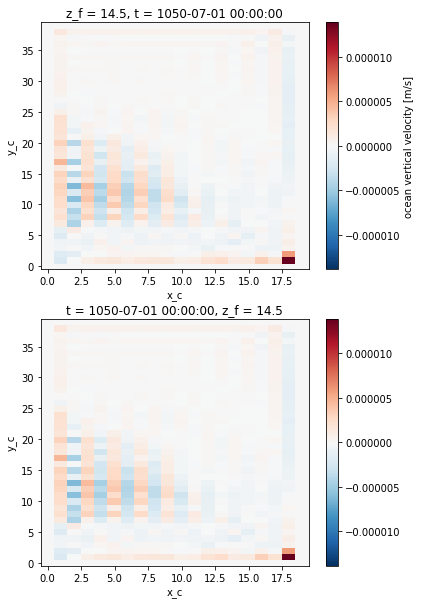

In [11]:
fig, ax = plt.subplots(2, 1)
ds.woce.isel({'z_f':1}).plot(ax=ax[0])
w.isel({'z_f':1}).plot(ax=ax[1])

The 2 fields look similar, which is confirmed by computing the difference.

In [12]:
abs((w - ds.woce)).max()

<xarray.DataArray ()>
array(2.07489191e-17)

### Vorticity
Here we compute more derived quantities from the velocity field.

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \ . $$

The NEMO discretization is [1]

$$
\zeta = \frac{1}{e_{1f} e_{2f}} \left[\delta_{i+1/2}(v \cdot e_{2v}) - \delta_{j+1/2}(u \cdot e_{1u}) \right] 
$$

<hr>
[1] NEMO book v4.0.1, pp 22
<hr>

In xgcm, we calculate this quantity as

In [13]:
zeta = 1/(domcfg.e1f*domcfg.e2f) * (grid.diff(ds.vo*domcfg.e2v, 'X', **bd) - grid.diff(ds.uo*domcfg.e1u, 'Y', **bd)) * domcfg.fmaskutil
zeta.coords

Coordinates:
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 15.5 16.5 17.5 18.5 19.5
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5
  * t        (t) object 1050-07-01 00:00:00
  * z_c      (z_c) float32 5.0 15.0 25.0 35.0 ... 3379.915 3786.7092 4219.6006

$\zeta$ is located in the F point (*x_f*, *y_f*).

We plot the vertical integral of this quantity, i.e. the barotropic vorticity:

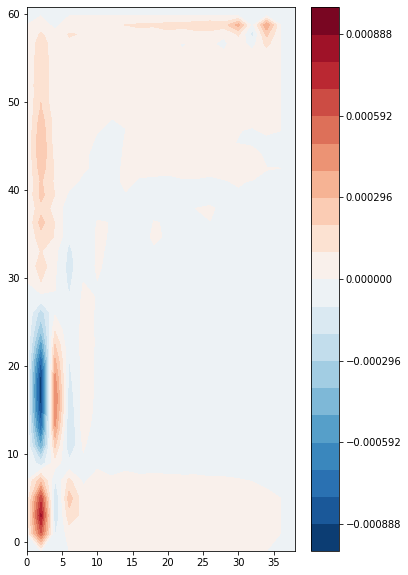

In [14]:
zeta_bt = (zeta * ds.e3f).sum(dim='z_c')
plt.contourf(
    domcfg.glamf,
    domcfg.gphif,
    zeta_bt.isel({'t':0}),
    levels=np.linspace(-abs(zeta_bt).max(), abs(zeta_bt).max(), 21),
    cmap='RdBu_r'
)
plt.colorbar()

### Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

$$ \Psi(x,y) = \int_0^x \int_{bottom}^{surface} v_{bt}(x,y) \, \text{d}z \, \text{d}x $$

We calculate this by integrating $v_{bt}$ along the X axis using the grid object's `cumint` method:

Coordinates:
  * t        (t) object 1050-07-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 15.5 16.5 17.5 18.5 19.5


(0, 60)

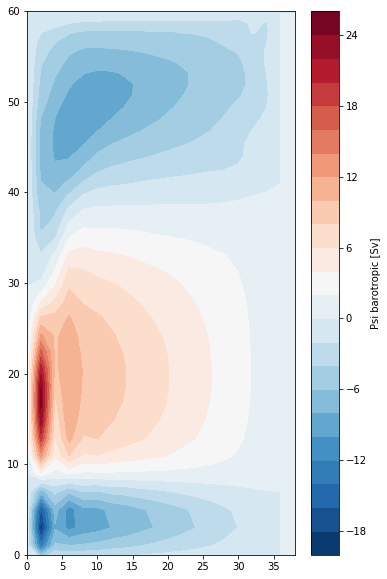

In [15]:
psi = grid.cumint((ds.vo*ds.e3v).sum(dim='z_c'),'X', **bd) * 1e-6
print(psi.coords)
plt.contourf(
    domcfg.glamf,
    domcfg.gphif,
    psi.isel({'t':0}),
    levels=25,
    cmap='RdBu_r'
)
plt.colorbar(label='Psi barotropic [Sv]')
plt.ylim(0,60)

By construction, $\psi$ is 0 at the western boundary.

### Kinetic Energy

Finally, we plot the surface kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

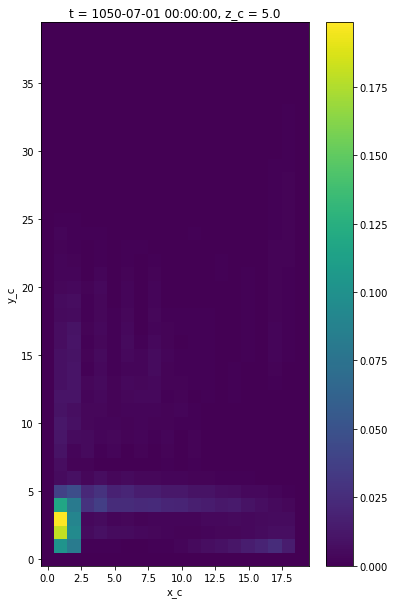

In [16]:
# an example of calculating kinetic energy
ke = 0.5*(grid.interp((ds.uo)**2, 'X', **bd) + grid.interp((ds.vo)**2, 'Y', **bd))
ke[0,0].plot()